# Regression Modelling

In [2]:
import pandas as pd
from pycaret.regression import *
from datetime import datetime, date
%matplotlib inline

#sen1 = pd.read_csv("sentencing_s.csv")
sen2 = pd.read_csv("./sentencing_post_eda.csv")

In [3]:
sen2.shape

(1227930, 47)

In [4]:
sen2.clfely.value_counts()

3RD DEGREE    924685
2ND DEGREE    246882
1ST DEGREE     41201
1ST/LIFE       13506
LIFE            1592
UNKNOWN           64
Name: clfely, dtype: int64

In [5]:
sen2.dtypes

Unnamed: 0            int64
Column2               int64
fstnm                object
lstnm                object
age                   int64
dob                  object
race                 object
gender               object
county               object
totpts              float64
judge                object
clfely               object
statut               object
offlvl               object
offdte               object
sentdte              object
sp_total_days         int64
spyrs                 int64
spmths                int64
spdays                int64
cj_total_days         int64
cc_total_days         int64
pr_total_days         int64
enhanc               object
haboff                 bool
habvio                 bool
life                 object
vcc                  object
prrpact              object
dornum               object
circuit              object
dispos               object
docket                int64
prioff                int64
ccimp                  bool
cjimp               

In [6]:
sen2[["age", "totpts", "sp_cj_total_days", "totpts_cut_group"]].describe().apply(lambda s: s.apply('{0:.2f}'.format))

,age,totpts,sp_cj_total_days,totpts_cut_group
count,1227930.00,1227930.00,1227930.00,1227930.00
mean,32.86,37.39,379.01,1.62
std,10.96,29.60,826.47,2.50
min,0.00,0.20,0.00,0.00
25%,24.00,18.40,0.00,0.00
50%,30.00,29.80,60.00,1.00
75%,41.00,43.40,366.00,1.00
max,114.00,199.60,13259.00,17.00


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'totpts'}>],
       [<AxesSubplot:title={'center':'sp_cj_total_days'}>,
        <AxesSubplot:title={'center':'totpts_cut_group'}>]], dtype=object)

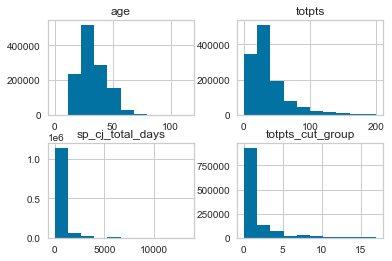

In [7]:
sen2[["age", "totpts", "sp_cj_total_days", "totpts_cut_group"]].hist()


In [8]:
sen2 = sen2[['sp_cj_total_days', 'gender', 'age', 'race', 'circuit', 'totpts_cut_group', 'clfely']]

data = sen2.sample(frac=0.9, random_state=786)
data_unseen = sen2.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (1105137, 7)
Unseen Data For Predictions: (122793, 7)


In [13]:
from pycaret.regression import *
X = setup(data = data, target = 'sp_cj_total_days', session_id=123, normalize = True, 
          transformation = True, #transform_target = True, 
          combine_rare_levels = True, rare_level_threshold = 0.05,
          remove_multicollinearity = True, multicollinearity_threshold = 0.95
          )

#X = setup(data = data, target = 'sp_cj_total_days', session_id=123, normalize = True, 
#          transformation = True, transform_target = True, 
#          combine_rare_levels = True, rare_level_threshold = 0.05,
#          remove_multicollinearity = True, multicollinearity_threshold = 0.95)

#, categorical_features = ['race', 'gender', 'county', 'judge', 'clfely']           
#['race', 'gender', 'county', 'judge', 'clfely', 'statut', 'offlvl', 'enhanc', 'haboff', 'habvio', 'vcc', 'prrpact', 'prioff', 'lsviol', 'faviol'])
          

,Description,Value
0,session_id,123
1,Target,sp_cj_total_days
2,Original Data,"(1105137, 7)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(773595, 50)"


In [14]:
best = compare_models(exclude = ['ransac'])


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,253.2576,312073.6127,558.6031,0.5426,3.0689,2.8385,2.0900
xgboost,Extreme Gradient Boosting,252.3864,313490.8200,559.8629,0.5406,3.0416,2.8304,37.7060
gbr,Gradient Boosting Regressor,264.6971,329330.7698,573.8389,0.5174,3.1696,3.1290,44.9760
ridge,Ridge Regression,266.3208,335005.3417,578.7640,0.5091,3.1473,3.1231,0.2560
lar,Least Angle Regression,266.3194,335005.7035,578.7643,0.5091,3.1473,3.1230,0.2750
br,Bayesian Ridge,266.3205,335005.3237,578.7640,0.5091,3.1473,3.1231,4.1260
lr,Linear Regression,266.3179,335005.3689,578.7640,0.5091,3.1473,3.1230,0.9950
lasso,Lasso Regression,267.1020,339383.7320,582.5346,0.5027,3.1452,3.2492,10.1140
par,Passive Aggressive Regressor,240.9136,356316.5177,596.8827,0.4778,2.4065,1.6110,1.2820
huber,Huber Regressor,244.6587,356453.3938,597.0051,0.4776,2.7340,2.1183,17.7930


In [15]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,253.8793,310930.4491,557.6114,0.5438,3.0708,2.9206
1,252.5110,302530.9067,550.0281,0.5510,3.0654,2.7567
2,254.4247,321980.7602,567.4335,0.5369,3.0772,2.9011
3,252.3863,311246.9594,557.8951,0.5474,3.0682,2.8370
4,257.0807,325013.1240,570.0992,0.5336,3.0743,2.8283
5,251.8988,308664.0562,555.5754,0.5436,3.0728,2.9096
6,253.4106,313058.3998,559.5162,0.5303,3.0589,2.8186
7,252.0116,303695.4468,551.0857,0.5377,3.0714,2.8407
8,251.9752,309319.9158,556.1654,0.5502,3.0664,2.8720
9,252.9974,314296.1085,560.6212,0.5520,3.0631,2.7007


In [16]:
import numpy as np
lgbm_params = {'num_leaves': np.arange(10,200,10),
                        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                        'learning_rate': np.arange(0.1,1,0.1)
                        }
tuned_lightgbm = tune_model(lightgbm, custom_grid = lgbm_params)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,253.3049,311761.1841,558.3558,0.5426,3.0680,2.9145
1,251.3463,302252.6186,549.7751,0.5514,3.0661,2.7536
2,253.8415,321926.2873,567.3855,0.5370,3.0778,2.9078
3,251.7033,310605.9047,557.3203,0.5484,3.0655,2.8367
4,256.3619,325358.1351,570.4017,0.5331,3.0760,2.8163
5,250.6932,308438.5030,555.3724,0.5439,3.0665,2.9048
6,253.0579,314076.9867,560.4257,0.5288,3.0601,2.7949
7,250.9191,303531.2231,550.9367,0.5379,3.0684,2.8529
8,251.2199,310247.9939,556.9991,0.5488,3.0634,2.8705
9,251.9663,313127.7853,559.5782,0.5536,3.0594,2.7069


In [8]:
print(tuned_lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=60,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=120, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


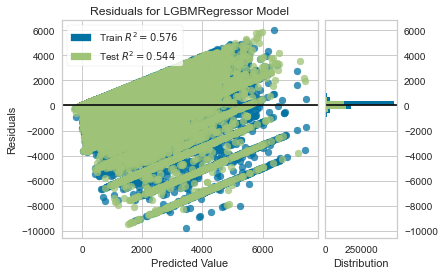

In [17]:
plot_model(tuned_lightgbm)


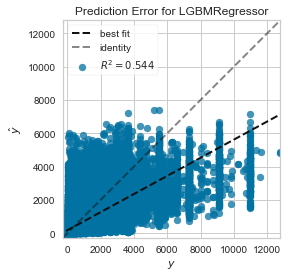

In [18]:
plot_model(tuned_lightgbm, plot = 'error')


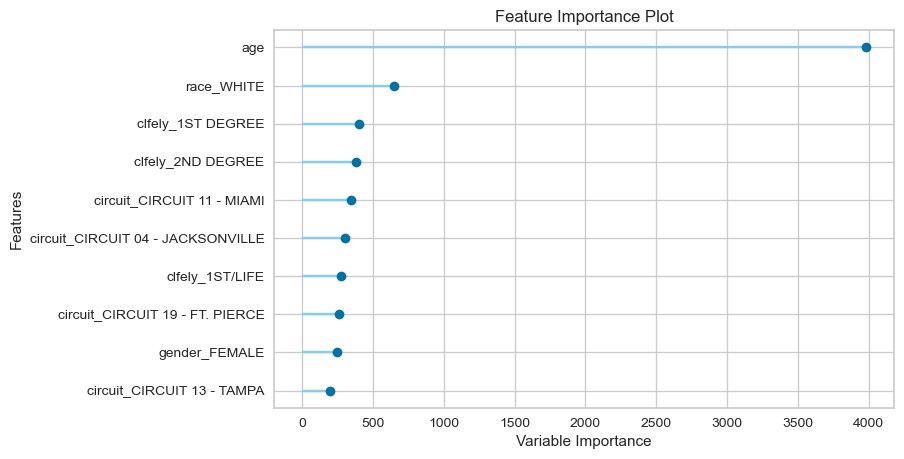

In [19]:
plot_model(tuned_lightgbm, plot='feature')


In [20]:
predict_model(tuned_lightgbm);


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,252.3177,313123.8777,559.5747,0.5438,3.0647,2.8948


In [21]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [22]:
print(final_lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=60,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=120, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [23]:
predict_model(final_lightgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,248.6926,294028.0696,542.2436,0.5716,3.0627,2.8801


In [24]:
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)
unseen_predictions.head(25)

,sp_cj_total_days,gender,age,race,circuit,totpts_cut_group,clfely,Label
0,3902,MALE,39,BLACK,CIRCUIT 11 - MIAMI,17,1ST DEGREE,2555.363645
1,3259,MALE,25,BLACK,CIRCUIT 17 - FT. LAUDERDALE,14,1ST/LIFE,3945.286783
2,5840,MALE,27,WHITE,CIRCUIT 11 - MIAMI,8,2ND DEGREE,1301.035361
3,660,MALE,31,BLACK,CIRCUIT 11 - MIAMI,4,2ND DEGREE,670.433049
4,1176,MALE,44,BLACK,CIRCUIT 04 - JACKSONVILLE,3,3RD DEGREE,790.995362
5,900,MALE,41,WHITE,CIRCUIT 06 - CLEARWATER,8,2ND DEGREE,2556.103614
6,2920,MALE,52,WHITE,CIRCUIT 11 - MIAMI,12,2ND DEGREE,1774.059328
7,1560,MALE,49,BLACK,CIRCUIT 20 - FT MYERS,7,1ST DEGREE,2035.329667
8,774,MALE,31,BLACK,CIRCUIT 11 - MIAMI,3,2ND DEGREE,584.420510
9,2938,MALE,45,WHITE,CIRCUIT 11 - MIAMI,13,1ST/LIFE,2464.809742


In [25]:
from pycaret.utils import check_metric
check_metric(unseen_predictions.sp_cj_total_days, unseen_predictions.Label, 'R2')

0.5448

In [18]:
check_metric(unseen_predictions[unseen_predictions.race=="BLACK"].sp_cj_total_days, unseen_predictions[unseen_predictions.race=="BLACK"].Label, 'R2')

0.4931

In [19]:
check_metric(unseen_predictions[unseen_predictions.race=="WHITE"].sp_cj_total_days, unseen_predictions[unseen_predictions.race=="WHITE"].Label, 'R2')

0.5242

In [26]:
save_model(final_lightgbm,'Final LightGBM Model Int 22Feb2022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='sp_cj_total_days',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric...
                  LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=60,
                                min_child_samples=20, min

In [21]:
get_config('X_train').shape

(773595, 47)

In [22]:
type(final_lightgbm)

lightgbm.sklearn.LGBMRegressor

In [23]:
!mlflow ui

[2022-02-21 23:50:06 -0800] [39687] [INFO] Starting gunicorn 20.1.0
[2022-02-21 23:50:06 -0800] [39687] [INFO] Listening at: http://127.0.0.1:5000 (39687)
[2022-02-21 23:50:06 -0800] [39687] [INFO] Using worker: sync
[2022-02-21 23:50:06 -0800] [39690] [INFO] Booting worker with pid: 39690
^C
[2022-02-22 05:50:21 -0800] [39687] [INFO] Handling signal: int
[2022-02-22 05:50:21 -0800] [39690] [INFO] Worker exiting (pid: 39690)


In [29]:
unseen_predictions.head(50)

,sp_cj_total_days,gender,age,race,circuit,totpts_cut_group,clfely,Label
0,3902,MALE,39,BLACK,CIRCUIT 11 - MIAMI,17,1ST DEGREE,2555.363645
1,3259,MALE,25,BLACK,CIRCUIT 17 - FT. LAUDERDALE,14,1ST/LIFE,3945.286783
2,5840,MALE,27,WHITE,CIRCUIT 11 - MIAMI,8,2ND DEGREE,1301.035361
3,660,MALE,31,BLACK,CIRCUIT 11 - MIAMI,4,2ND DEGREE,670.433049
4,1176,MALE,44,BLACK,CIRCUIT 04 - JACKSONVILLE,3,3RD DEGREE,790.995362
5,900,MALE,41,WHITE,CIRCUIT 06 - CLEARWATER,8,2ND DEGREE,2556.103614
6,2920,MALE,52,WHITE,CIRCUIT 11 - MIAMI,12,2ND DEGREE,1774.059328
7,1560,MALE,49,BLACK,CIRCUIT 20 - FT MYERS,7,1ST DEGREE,2035.329667
8,774,MALE,31,BLACK,CIRCUIT 11 - MIAMI,3,2ND DEGREE,584.420510
9,2938,MALE,45,WHITE,CIRCUIT 11 - MIAMI,13,1ST/LIFE,2464.809742


In [30]:
X

(123,
 {'lr': <pycaret.containers.models.regression.LinearRegressionContainer at 0x7fcb5afa30d0>,
  'lasso': <pycaret.containers.models.regression.LassoRegressionContainer at 0x7fcb5afa3310>,
  'ridge': <pycaret.containers.models.regression.RidgeRegressionContainer at 0x7fcb5afa3650>,
  'en': <pycaret.containers.models.regression.ElasticNetContainer at 0x7fcb5afa3790>,
  'lar': <pycaret.containers.models.regression.LarsContainer at 0x7fcb5afa3910>,
  'llar': <pycaret.containers.models.regression.LassoLarsContainer at 0x7fcb5afa3a90>,
  'omp': <pycaret.containers.models.regression.OrthogonalMatchingPursuitContainer at 0x7fcb5afa3c10>,
  'br': <pycaret.containers.models.regression.BayesianRidgeContainer at 0x7fcb5afa3d50>,
  'ard': <pycaret.containers.models.regression.AutomaticRelevanceDeterminationContainer at 0x7fcb5afa3f90>,
  'par': <pycaret.containers.models.regression.PassiveAggressiveRegressorContainer at 0x7fcb5afa3a50>,
  'ransac': <pycaret.containers.models.regression.RANSACRe

In [46]:
get_config('X_train').dtypes

age                                     float32
gender_FEMALE                           float32
race_OTHER                              float32
race_WHITE                              float32
circuit_CIRCUIT 01 - PENSACOLA          float32
circuit_CIRCUIT 02 - TALLAHASSEE        float32
circuit_CIRCUIT 03 - LAKE CITY          float32
circuit_CIRCUIT 04 - JACKSONVILLE       float32
circuit_CIRCUIT 05 - TAVARES            float32
circuit_CIRCUIT 06 - CLEARWATER         float32
circuit_CIRCUIT 07 - DAYTONA BEACH      float32
circuit_CIRCUIT 08 - GAINESVILLE        float32
circuit_CIRCUIT 09 - ORLANDO            float32
circuit_CIRCUIT 10 - BARTOW             float32
circuit_CIRCUIT 11 - MIAMI              float32
circuit_CIRCUIT 12 - SARASOTA           float32
circuit_CIRCUIT 13 - TAMPA              float32
circuit_CIRCUIT 14 - PANAMA CITY        float32
circuit_CIRCUIT 15 - WEST PALM BEACH    float32
circuit_CIRCUIT 16 - KEY WEST           float32
circuit_CIRCUIT 17 - FT. LAUDERDALE     